# Imports

In [ ]:
import pandas as pd
from json_functions import create_df_big_output, create_example

players_list, df = create_df_big_output('very-big.json', mirror=True)

In [ ]:
import numpy as np
import tensorflow as tf
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow.keras.backend as K 

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

# Check GPU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create dataset from json file

In [ ]:
features, outputs = df["rosters vector"], df['rating vector']

features = pd.DataFrame(features.values.tolist(), index= df.index)
outputs = pd.DataFrame(outputs.values.tolist(), index= df.index)

print(np.shape(features))
print(np.shape(outputs))

(17488, 1068)
(17488, 1068)


In [ ]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, outputs, test_size=0.1, random_state=42)

# I'm just going to use train_test_split again to create a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

validation_ds = (X_val, y_val)

In [ ]:
print(len(X_train))
print(len(X))

14165
15739


# Set a global batch size and steps per epoch

I need to set the global batch size for my custom loss function to work.

In [ ]:
# I'll use steps per epoch instead of batch size because my custom loss function could be innacurate on a smaller batch at end of training set
GLOBAL_BATCH_SIZE = 329
STEPS_PER_EPOCH = len(X_train)//GLOBAL_BATCH_SIZE

# Create custom loss function

In [ ]:
# create loss function that only takes into account values from the output dont have a true value of 0
class Filtered_MAE(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):
        loss = my_loss(y_true, y_pred)
        loss_divided_by_batch = tf.divide(loss, GLOBAL_BATCH_SIZE)
        return loss_divided_by_batch

The sigmoid defined by my_step is very close to a step function, if x = 0, then it will return nearly 0, and if x is a reasonable rating value, even something as low as 0.4, it will return (pretty much) 1. I will plug in y_true to this and then multiply the result by the error so that error on predictions where where y_true = 0 becomes tiny but where y_true is an actual rating stays pretty much the same

In [ ]:
def my_loss(y_true, y_pred):
    
    def my_step(x):
        return tf.divide(1.0, tf.add(1.0, tf.exp(tf.multiply(-1000.0, tf.subtract(x, 0.02)))))
    
    # we can hardcode denominator as 10 since we know that there will always be 10 relevent values
    # in this case I just multiply by 0.1 for simplicity  
    loss = tf.multiply(0.1, tf.reduce_sum(tf.multiply(my_step(y_true), tf.abs(tf.subtract(y_pred, y_true)))))
    loss_per_batch = tf.divide(loss, GLOBAL_BATCH_SIZE)
    return loss

    # return K.in_train_phase(0, loss)
    # return loss_per_batch

# Set up tensorboard

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Create Compile and fit fucntion

In [ ]:
def compile_and_fit(model, 
                    name,
                    max_epochs=1000, 
                    initial_lr=0.001, 
                    es_patience=50,
                    verbose=0):

    # Reduce the learning rate as training goes on
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_lr,
        decay_steps=STEPS_PER_EPOCH*0.1*max_epochs,
        decay_rate=1,
        staircase=False)
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=es_patience, 
                                                      verbose=1)

    model.compile(loss=Filtered_MAE(),
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))
    
    for output in model.outputs:
        output._uses_learning_phase = True

    model.summary()

    history = model.fit(X_train,
                        y_train, 
                        verbose=verbose, 
                        epochs=max_epochs,
                        # steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size = GLOBAL_BATCH_SIZE,
                        validation_data=validation_ds,
                        validation_batch_size = GLOBAL_BATCH_SIZE,
                        # validation_steps=STEPS_PER_EPOCH//10,
                        callbacks=[early_stopping,
                                   tf.keras.callbacks.TensorBoard(logdir/name)])
    print("Evaluation on test set:")
    mae = model.evaluate(X_test, y_test,
                         verbose=1,
                         batch_size = GLOBAL_BATCH_SIZE)
    
    return history


# Train a few models with different Architectures

In [ ]:
n_inputs, n_outputs = features.shape[1], outputs.shape[1]
n_inputs

1068

In [ ]:
linear_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='linear')
])

In [ ]:
histories = {}
histories['linear'] =  compile_and_fit(model=linear_perceptron_model,
                                       name='linear',
                                       initial_lr=0.005)


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 00052: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 3ms/step - loss: 0.2705


In [ ]:
tanh_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='tanh')
])

In [ ]:
histories['tanh_peceptron'] = compile_and_fit(model=tanh_perceptron_model,
                                              name='tanh_peceptron',
                                              initial_lr=0.005)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 00063: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2524


In [ ]:
medium_model = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dense(500, activation='relu'),
    Dense(n_outputs)
])
histories['medium_model'] = compile_and_fit(model=medium_model,
                                            name='medium_model',
                                            initial_lr=0.001)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_86 (Dense)             (None, 500)               534500    
_________________________________________________________________
dense_87 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00053: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2617


In [ ]:
from tensorflow.keras import regularizers
medium_model_regularized = Sequential([
    Dense(1068, 
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dense(500, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories['medium_model_reg'] = compile_and_fit(model=medium_model_regularized,
                                                name='medium_model_reg', 
                                                max_epochs=1000, 
                                                initial_lr=0.001)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_89 (Dense)             (None, 500)               534500    
_________________________________________________________________
dense_90 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00142: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2326


In [ ]:
medium_model_dropout = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_model_dropout'] = compile_and_fit(model=medium_model_dropout,
                                                    name='medium_model_dropout',
                                                    max_epochs=1000,
                                                    initial_lr=0.001)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 500)               534500    
_________________________________________________________________
dropout_35 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00053: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss

In [ ]:
medium_model_dropout_regularized = Sequential([
    Dense(1068,
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dropout(0.5),
    Dense(500, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_dropout_regularized'] = compile_and_fit(model=medium_model_dropout_regularized, 
                                                          name='medium_dropout_regularized',
                                                          max_epochs=1000, 
                                                          initial_lr=0.001)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_36 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 500)               534500    
_________________________________________________________________
dropout_37 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00195: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 3ms/step - loss

Text(0.5, 0, 'Epochs')

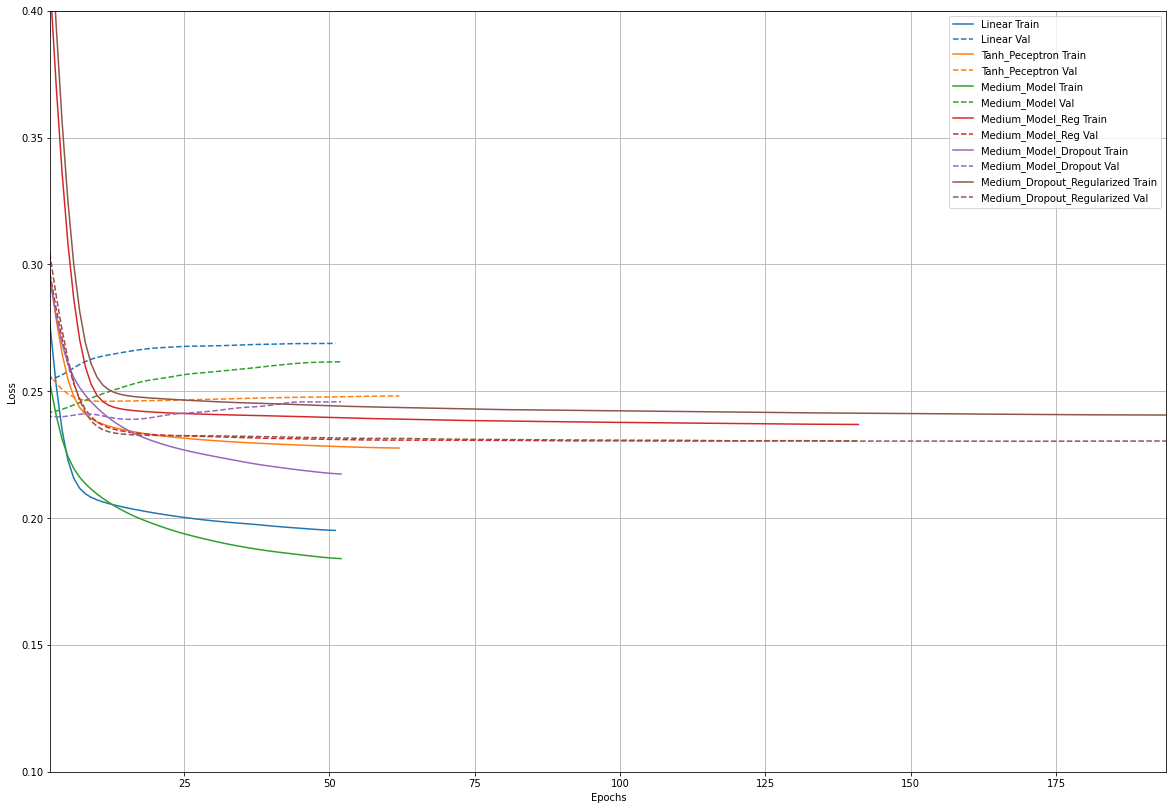

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories)
# a = plt.xscale('log')
plt.xlim([2, max(plt.xlim())])
plt.ylim([0.1, 0.4])
plt.xlabel("Epochs")

The medium model with dropout and regularization performed the best so far

## Train a particularly big model

This model has over 10k hidden units. 

In [ ]:
huge_regularize_dropout_model = Sequential([
    Dense(2000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(4000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(8000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(4000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(2000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['huge_regularized_dropout'] = compile_and_fit(model=huge_regularize_dropout_model, 
                                                        name='huge_regularized_dropout',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=1)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 2000)              2138000   
_________________________________________________________________
dropout_50 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 4000)              8004000   
_________________________________________________________________
dropout_51 (Dropout)         (None, 4000)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 8000)              32008000  
_________________________________________________________________
dropout_52 (Dropout)         (None, 8000)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 4000)            

In [ ]:
histories

{'huge_regularized_dropout': <tensorflow.python.keras.callbacks.History at 0x7f0c6590cad0>,
 'medium_dropout_regularized': <tensorflow.python.keras.callbacks.History at 0x7f0c3a457f10>,
 'medium_model_reg': <tensorflow.python.keras.callbacks.History at 0x7f0c570af150>,
 'tanh_peceptron': <tensorflow.python.keras.callbacks.History at 0x7f0c56326990>}

Text(0.5, 0, 'Epochs [Log Scale]')

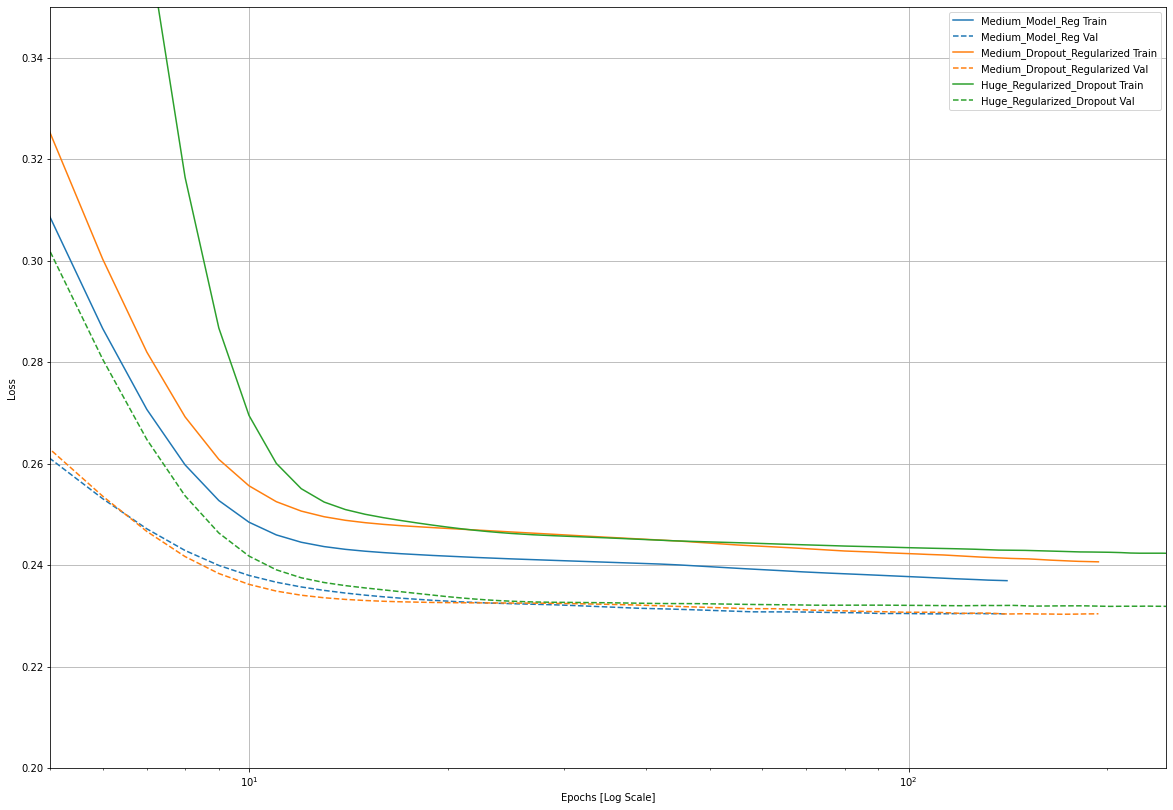

In [ ]:
# histories_reduced = histories
# histories_reduced.pop('linear')
# histories_reduced.pop('medium_model')
# histories_reduced.pop('medium_model_dropout')
# histories_reduced.pop('tanh_peceptron')

plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories_reduced)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.2, 0.35])
plt.xlabel("Epochs [Log Scale]")

Despite being way bigger than the medium model the huge model perform no better. I think this implies that the problem is only solvable to this degree with the information I'm giving the model.

In [ ]:
medium_model_regularized.save('med_l2reg.h5')

# Expirement with our model

In [193]:
model = medium_model_regularized


## Function to print the output of a single prediction

In [210]:
def print_prediction(example, players_list, model):
    player_indices = [i for i, x in enumerate(example) if x == 1]
    example_formatted = np.asarray([example])
    pred = model.predict(example_formatted)

    relevent_preds = np.zeros(10)

    print("Team 1:")
    for i, player  in enumerate(player_indices):
        if player >= len(players_list): player =player - len(players_list)
        print(f'{players_list[player]:10} {round(pred[0][player], 2):.2f}')
        relevent_preds[i] = round(pred[0][player], 2) 
        if i == 4:
            print("Agregate Rating:", round(np.sum(relevent_preds[0:5]), 2))
            print("Team 2:")
        if i == 9:
            print("Agregate Rating:", round(np.sum(relevent_preds[5:10]), 2))


## Predict on some games

In [211]:
hypothetical = create_example(['EliGE', 'Stewie2K', 'Grim', 'FalleN', 'NAF'], ['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], players_list)


In [212]:
print_prediction(hypothetical, players_list, model)

Team 1:
EliGE      1.04
NAF        1.01
Stewie2K   0.88
FalleN     0.90
Grim       0.96
Agregate Rating: 4.79
Team 2:
device     1.20
dupreeh    1.14
Xyp9x      1.09
gla1ve     1.05
Magisk     1.15
Agregate Rating: 5.63


Let's compare these results to a real game played between these two teams that happened after I collected the training data (the model hasn't seen this game):

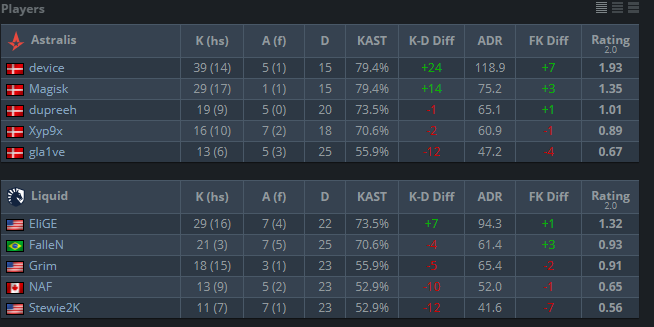
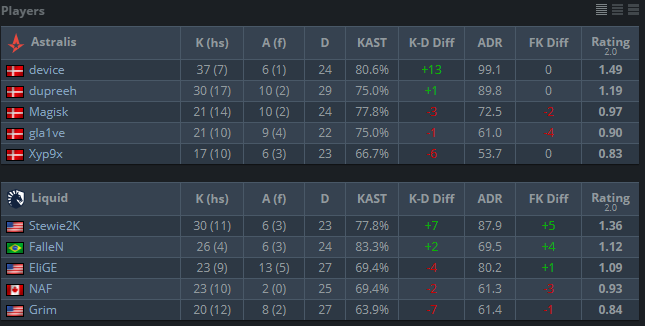

Well, it didn't do a fantastic job at predicting individual ratings here. But at least it knew device would do the best on Astralis. I guess its not surprising that the model doesn't predict super well on individual games since performance can vary so extremely from game to game (as exemplified by Stewie2K here)

One thing it does get right is the winner of the game, if we assume that whoever has the higher agregate rating would win (It would be virtually impossible to win a CSGO game with a team that has a lower agregate rating, so this is a fair assumption)

Lets check that the order of teams doesn't have too much of an effect on the results:

In [222]:
hypothetical = create_example(['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], ['EliGE', 'Stewie2K', 'Grim', 'FalleN', 'NAF'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
device     1.20
dupreeh    1.14
Xyp9x      1.10
gla1ve     1.05
Magisk     1.15
Agregate Rating: 5.64
Team 2:
EliGE      1.04
NAF        1.02
Stewie2K   0.89
FalleN     0.90
Grim       0.96
Agregate Rating: 4.81


So the order of the teams doesn't matter. That's good.

## Old Astralis vs New Astralis

Here's a hypothetical game that could never happen: 2016 Astralis vs current Astralis. Current Astralis is the most dominant CSGO roster of all time, so we would expect to see higher ratings accross the board for them, which we do. (They are team 2 here).

In [223]:
hypothetical = create_example(['device', 'Xyp9x', 'Kjaerbye', 'dupreeh', 'karrigan'], ['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
karrigan   0.73
device     1.15
dupreeh    1.10
Xyp9x      1.04
Kjaerbye   0.86
Agregate Rating: 4.88
Team 2:
device     1.15
dupreeh    1.10
Xyp9x      1.04
gla1ve     1.00
Magisk     1.10
Agregate Rating: 5.39


Let's see how the model says each of these Astralis's would do against FaZe

In [224]:
hypothetical = create_example(['device', 'Xyp9x', 'Kjaerbye', 'dupreeh', 'karrigan'], ['flamie', 's1mple', 'electronic', 'Boombl4', 'Perfecto'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
karrigan   0.78
device     1.20
dupreeh    1.13
Xyp9x      1.09
Kjaerbye   0.90
Agregate Rating: 5.1
Team 2:
s1mple     1.24
flamie     0.91
electronic 1.11
Boombl4    0.98
Perfecto   0.94
Agregate Rating: 5.18


In [220]:
hypothetical = create_example(['device', 'Xyp9x', 'Magisk', 'dupreeh', 'gla1ve'], ['flamie', 's1mple', 'electronic', 'Boombl4', 'Perfecto'], players_list)
print_prediction(hypothetical, players_list, model)

Team 1:
device     1.15
dupreeh    1.09
Xyp9x      1.03
gla1ve     1.00
Magisk     1.09
Agregate Rating: 5.36
Team 2:
s1mple     1.20
flamie     0.86
electronic 1.07
Boombl4    0.96
Perfecto   0.90
Agregate Rating: 4.99


The model says that Old Astralis loses to NaVi while New Astralis wins, which seems pretty much right to me. The model shows that niether device, dupreeh, or Xyp9x perform as well on new astralis, but the rest of the team performs better which more than makes up for it. 

Intuitively this seems right, as Astralis is known for dominating while no one player carries the game. Every player contributes so no individual needs to "pop off".

In [ ]:
#TODO
# choose a player, hold opponents equal, then loop thru all possible teammates
# to find best teammates.
# hold 3 teammates equal to find best teammate
